In [1]:
from pylab import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

DATA_PATH = "D:/data/school/" # Make this the /path/to/the/data

# import data

In [2]:
data_class_size = pd.read_csv(DATA_PATH + "2010-2011_Class_Size_-_School-level_detail.csv")
data_graduation = pd.read_csv(DATA_PATH + "Graduation_Outcomes_-_Classes_Of_2005-2010_-_School_Level.csv")
data_sat_results = pd.read_csv(DATA_PATH + "SAT_Results.csv")
data_attendance = pd.read_csv(DATA_PATH + 'School_Attendance_and_Enrollment_Statistics_by_District__2010-11_.csv')
data_school_grade = pd.read_csv(DATA_PATH + 'School_Progress_Report_2010-2011.csv')
data_graduation_new = pd.read_csv(DATA_PATH + "Graduation_Outcomes_-_School_Level_-_Classes_2010-2011_-_Regents-based_Math_ELA_APM_-_Total_Cohort.csv")


# Data Clean

### Class size data

In [3]:
def add_DBN_to_class(row):
    dbn = "{0:02d}{1}".format(row["CSD"], row["SCHOOL CODE"])
    return dbn
    
data_class_size["DBN"] = data_class_size.apply(add_DBN_to_class, axis=1)

In [4]:
class_size_temp = data_class_size.drop(['CSD', 'BOROUGH', 'SCHOOL CODE'], 1)
class_size_temp = class_size_temp[class_size_temp["GRADE "] == '09-12']
class_size_temp = class_size_temp[class_size_temp["PROGRAM TYPE"] == 'GEN ED']
class_size_temp = class_size_temp.groupby("DBN").agg(np.mean)

In [25]:
data_class_size_final = class_size_temp.reset_index()
data_class_size_final = data_class_size_final[['DBN', 'AVERAGE CLASS SIZE']]

### SAT result

In [6]:
sat_results_temp = data_sat_results.drop("Num of SAT Test Takers", 1)
sat_results_temp['SAT Math Avg. Score'] = sat_results_temp['SAT Math Avg. Score'].convert_objects(convert_numeric = True)
sat_results_temp['SAT Critical Reading Avg. Score'] = sat_results_temp['SAT Critical Reading Avg. Score'].convert_objects(convert_numeric = True)
sat_results_temp['SAT Writing Avg. Score'] = sat_results_temp['SAT Writing Avg. Score'].convert_objects(convert_numeric = True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [7]:
sat_results_temp["Total_Avg"] = sat_results_temp.apply(lambda x: x['SAT Math Avg. Score'] + x['SAT Critical Reading Avg. Score'] + x['SAT Writing Avg. Score'], axis=1)

In [48]:
sat_results_temp = sat_results_temp.rename(columns={"Total_Avg":"SAT_Avg",})
sat_results_final = sat_results_temp[['DBN', 'SAT_Avg']]

### Attendance

In [42]:
attendance_temp = data_attendance
attendance_temp['District'] = data_attendance.apply(lambda x: x['District'].replace('DISTRICT ', ''), axis=1)
attendance_temp = attendance_temp.drop([33, 34])
attendance_temp['District'] = attendance_temp.apply(lambda x: x['District'].replace('SPECIAL ED ', ''), axis=1)
attendance_temp['YTD % Attendance (Avg)'] = attendance_temp.apply(lambda x: x['YTD % Attendance (Avg)'].replace('%', ''), axis=1)
attendance_temp = attendance_temp.rename(columns={'YTD % Attendance (Avg)':'Avg_ttendance', 'YTD Enrollment(Avg)':'Avg_enrollment'})


In [43]:
attendance_temp.dtypes

District          object
Avg_ttendance     object
Avg_enrollment     int64
dtype: object

In [44]:
attendance_temp = attendance_temp.rename(columns={'Avg_ttendance':"Avg_atendance" })
attendance_temp['Avg_atendance'] = attendance_temp['Avg_atendance'].convert_objects(convert_numeric = True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [45]:
attendance_final = attendance_temp

### School grade data

In [12]:
school_grade_temp = data_school_grade[data_school_grade["SCHOOL LEVEL*"] == "High School"]

In [13]:
school_grade_temp = school_grade_temp.drop(["DISTRICT", "SCHOOL", "PRINCIPAL", "PROGRESS REPORT TYPE", "SCHOOL LEVEL*"], axis=1)

In [14]:
school_grade_final = school_grade_temp.rename(columns={'\ufeffDBN':'DBN'})

### Merge data

In [26]:
len(data_sat_results)

478

In [27]:
len(data_class_size_final)

583

In [28]:
sat_class_size = pd.merge(data_class_size_final, sat_results_final, how='inner', on='DBN')
sat_class_size = sat_class_size.dropna()

In [29]:
sat_class_size_temp = sat_class_size
sat_class_size_temp['District'] = sat_class_size_temp.apply(lambda x: x['DBN'][0:2], axis=1)

In [30]:
sat_size_atte = pd.merge(sat_class_size_temp, attendance_final, how='inner', on='District')

In [31]:
sat_size_atte_grade = pd.merge(sat_size_atte, school_grade_final, how='inner', on='DBN')

In [32]:
grade_remove_col = ["2010-2011 OVERALL GRADE", "2010-2011 ENVIRONMENT GRADE", "2010-2011 PERFORMANCE GRADE", "2010-2011 PROGRESS GRADE", "2010-2011 ADDITIONAL CREDIT", "2009-10 PROGRESS REPORT GRADE"]

In [33]:
sat_size_atte_grade_temp = sat_size_atte_grade.drop(grade_remove_col, axis=1)

In [34]:
sat_size_atte_grade_temp = sat_size_atte_grade_temp.dropna()


# Visualizing data

In [38]:
list(sat_size_atte_grade_temp.columns.values)

['DBN',
 'AVERAGE CLASS SIZE',
 'SAT_Avg',
 'District',
 'Avg_atendance',
 'Avg_enrollment',
 'PEER INDEX*',
 '2010-2011 OVERALL SCORE',
 '2010-2011 ENVIRONMENT CATEGORY SCORE',
 '2010-2011 PERFORMANCE CATEGORY SCORE',
 '2010-2011 PROGRESS CATEGORY SCORE']

In [39]:
sat_size_atte_grade_temp.dtypes

DBN                                      object
AVERAGE CLASS SIZE                      float64
SAT_Avg                                 float64
District                                 object
Avg_atendance                            object
Avg_enrollment                            int64
PEER INDEX*                             float64
2010-2011 OVERALL SCORE                 float64
2010-2011 ENVIRONMENT CATEGORY SCORE    float64
2010-2011 PERFORMANCE CATEGORY SCORE    float64
2010-2011 PROGRESS CATEGORY SCORE       float64
dtype: object

ValueError: First argument must be a sequence

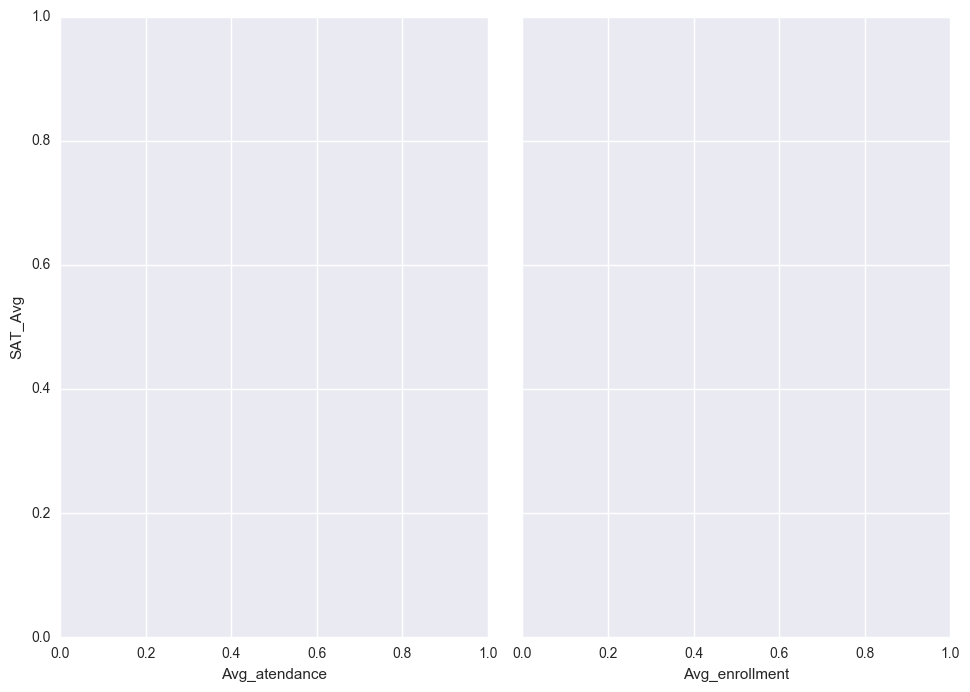

In [36]:
sns.pairplot(sat_size_atte_grade_temp, x_vars=[ 'Avg_atendance',
                                               'Avg_enrollment'],
             y_vars='SAT_Avg', size=7, aspect=0.7, kind='reg')

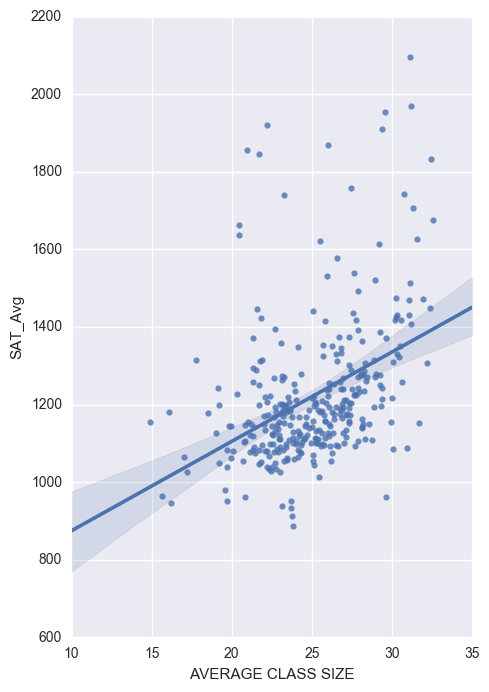

In [37]:
sns.pairplot(sat_size_atte_grade_temp, x_vars=['AVERAGE CLASS SIZE'],
             y_vars='SAT_Avg', size=7, aspect=0.7, kind='reg')

# Linear regression


In [ ]:
feature_cols = ['AVERAGE CLASS SIZE','Avg_atendance','Avg_enrollment','PEER INDEX*', 
                '2010-2011 OVERALL SCORE','2010-2011 ENVIRONMENT CATEGORY SCORE',
                '2010-2011 PERFORMANCE CATEGORY SCORE','2010-2011 PROGRESS CATEGORY SCORE']

In [ ]:
data_feature = sat_size_atte_grade_temp[feature_cols]

In [ ]:
data_target = sat_size_atte_grade_temp['SAT_Avg']